# CS221 Final Project: Classical Music Classification by Musical Era

This project aims to classify classical music by musical era (Baroque, Classical, Romantic, Modern) with composers as a proxy. Using audio processing techniques, such as Short-time Fourier Transform, we extracted features like spectrogram and chromagram of the audio data from two datasets, Free Music Archive and MAESTRO dataset. We used two ensemble classifiers,  AdaBoost and Random Forest, and found that although Adaboost performed marginally better than Random Forest, the latter made more generalizable predictions. Both models achieve an accuracy rate of 60\% on the test data, which is significantly better than the baseline prediction of 45\%. Our project reveals the complexity of the era classification task, and we expect more complex models trained on a larger data set to achieve higher success. 

In [1]:
%matplotlib inline

import os

import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import csv
import librosa
import soundfile as sf

from pydub import AudioSegment
from random import randint

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

METADATA_DIR = "./fma_metadata/"

# Datasets
Our model was trained, developed, and tested on a combination of the following two datasets:

1. *FMA (Free Music Archive)*: a large-scale dataset of audio files with rich metadata, containing over 100,000 tracks across 161 genres (Defferrard et al). From this dataset, we found 441 tracks that were categorized as "classical" and had a valid composer. 

2. *MAESTRO (MIDI and Audio Edited for Synchronous TRacks and Organization)*: a dataset with over 200 hours of labeled piano performances from 10 years of the International Piano-e-Competition, a piano competition that uses digital piano and records the music. This dataset contained 1282 songs that we could use in our model, making it the largest source of data for our project. Furthermore, we used the suggested 80-10-10 split, which eliminates overlap of pieces between training and test set. 

In total, our dataset consisted of 1723 songs, and we sampled the first 30 seconds of each song for feature extraction because practically a classifier should be able to make predictions with a limited exposure to the data.
The songs were overwhelmingly from the Romantic period, with 789 Romantic songs in our dataset.
In addition, we had 541 songs from the Baroque era, 280 from the Classical period, and 113 from the Modern era. The imbalance in the dataset may pose an over-fitting problem. 

# Feature Extraction
We used an audio processing library for Python called librosa to extract the following features using Short-time Fourier Transform from each audio file: chromagram, spectral centroid, spectral rolloff, root mean square value (RMS), and tonal centroid of a track. The chromagram is a distribution of the pitches in a track. The spectral centroid is a measure of the weighted mean of the frequencies over time in a sample of each data point. The spectral rolloff is the frequency below which 85\% of the spectral energy lies. We expect this feature to be a strong factor because the most distinguishing factor across era is the distribution of spectral energy. The root mean square feature takes the root mean square value of the spectrogram, the distribution of frequency over time.  Lastly, the tonal centroid meaures harmonic properties of the pitches. We also expect to see high weight on this feature because another major distinction between the music from the earlier eras (Baroque and Classical) and the later eras, (Romantic and Modern), are the extent or lack of harmony. For each of the five features, we normalized and computed the mean and standard deviation. 

In [2]:
def parse_dataset(metadata, composer_era_map):
    """Given a csv file with metadata from the MAESTRO database,
    this method extracts the features from the audio files corresponding
    to the data in the csv files and maps them to the correct era.
    The method returns data that can be used by a machine learning algorithm.
    """
    x = []
    y = []
    with open(metadata, "r") as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            composer = row[0]
            if composer == "canonical_composer": continue

            era = composer_era_map[composer]
            audio_file = "./maestro-v2.0.0/" + row[5]
            song = AudioSegment.from_wav(audio_file)
            song_length = len(song)
            if song_length > 30000:
                short_length = song_length - 30000
                rand_point = randint(0, short_length)
                splice = song[rand_point: rand_point + 30000]
            else:
                splice = song
            splice.export(audio_file[:-4] + "_short.wav", format="wav")
            features = get_features(audio_file[:-4] + "_short.wav")
            y.append(era)
            x.append(features)
    return x, y

In [3]:
def get_features(audio_file_path):
    """Given the path of an audio file, this method extracts the features
    using librosa and returns the features as an array of 10 float values.
    """
    features = []
    def feature_stats(name, values):
        features.append(np.mean(values))
        features.append(np.std(values))
    
    x, sr = librosa.load(audio_file_path, sr=None, mono=True)
    stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
    
    f = librosa.feature.spectral_centroid(S=stft)[0]
    feature_stats('spectral_centroid', f)
    
    f = librosa.feature.chroma_stft(S=stft**2, n_chroma=12)[0]
    feature_stats('chroma_stft', f)
    
    f = librosa.feature.spectral_rolloff(S=stft)[0]
    feature_stats('spectral_rolloff', f)
    
    f = librosa.feature.rmse(S=stft)[0]
    feature_stats('rmse', f)
    
    
    cqt = np.abs(librosa.cqt(x, sr=sr, hop_length=512, bins_per_octave=12, n_bins=7*12, tuning=None))
    f = librosa.feature.chroma_cens(C=cqt, n_chroma=12, n_octaves=7)
    f = librosa.feature.tonnetz(chroma=f)[0]
    feature_stats('tonnetz', f)
    
    return features

In [4]:
metadata = "./maestro-v2.0.0/maestro-v2.0.0.csv"
composer_era_map = {"Bach":"Baroque", "Haydn":"Classical",
                    "Alkan":"Romantic", "Orff":"Modern",
                    "Alban Berg":"Modern", "Alexander Scriabin":"Modern",
                    "Anton Arensky":"Romantic", "Antonio Soler": "Classical",
                    "Carl Maria von Weber":"Romantic", "Charles Gounod / Franz Liszt":"Romantic",
                    "Claude Debussy":"Modern", "César Franck":"Romantic", "Domenico Scarlatti":"Baroque",
                    "Edvard Grieg":"Romantic", "Felix Mendelssohn":"Romantic",
                    "Felix Mendelssohn / Sergei Rachmaninoff":"Romantic", "Franz Liszt":"Romantic",
                    "Franz Liszt / Camille Saint-Saëns":"Romantic", "Franz Liszt / Vladimir Horowitz":"Romantic",
                    "Franz Schubert":"Romantic", "Franz Schubert / Franz Liszt":"Romantic",
                    "Franz Schubert / Leopold Godowsky":"Romantic", "Fritz Kreisler / Sergei Rachmaninoff":"Romantic",
                    "Frédéric Chopin":"Romantic", "George Enescu":"Modern", "George Frideric Handel":"Baroque",
                    "Georges Bizet / Ferruccio Busoni":"Romantic", "Georges Bizet / Moritz Moszkowski":"Romantic",
                    "Georges Bizet / Vladimir Horowitz":"Romantic", "Giuseppe Verdi / Franz Liszt":"Romantic",
                    "Henry Purcell":"Baroque", "Isaac Albéniz":"Romantic", "Isaac Albéniz / Leopold Godowsky":"Romantic",
                    "Jean-Philippe Rameau":"Baroque", "Johann Christian Fischer / Wolfgang Amadeus Mozart":"Classical",
                    "Johann Pachelbel":"Baroque", "Johann Sebastian Bach":"Baroque",
                    "Johann Sebastian Bach / Egon Petri":"Baroque", "Johann Sebastian Bach / Ferruccio Busoni":"Baroque",
                    "Johann Sebastian Bach / Franz Liszt":"Romantic", "Johann Sebastian Bach / Myra Hess":"Baroque",
                    "Johann Strauss / Alfred Grünfeld":"Romantic", "Johannes Brahms":"Romantic",
                    "Joseph Haydn":"Classical", "Leoš Janáček":"Modern", "Ludwig van Beethoven":"Classical",
                    "Mikhail Glinka / Mily Balakirev":"Classical", "Mily Balakirev":"Romantic",
                    "Modest Mussorgsky":"Romantic", "Muzio Clementi":"Classical", "Niccolò Paganini / Franz Liszt":"Romantic",
                    "Nikolai Medtner":"Romantic", "Nikolai Rimsky-Korsakov / Sergei Rachmaninoff":"Romantic",
                    "Orlando Gibbons":"Baroque", "Percy Grainger":"Modern",
                    "Pyotr Ilyich Tchaikovsky":"Romantic", "Pyotr Ilyich Tchaikovsky / Mikhail Pletnev":"Romantic",
                    "Pyotr Ilyich Tchaikovsky / Sergei Rachmaninoff":"Romantic", "Richard Wagner / Franz Liszt":"Romantic",
                    "Robert Schumann":"Romantic", "Robert Schumann / Franz Liszt":"Romantic", "Sergei Rachmaninoff":"Romantic",
                    "Sergei Rachmaninoff / György Cziffra":"Romantic", "Sergei Rachmaninoff / Vyacheslav Gryaznov":"Romantic",
                    "Wolfgang Amadeus Mozart":"Classical"
                   }
maestro_x, maestro_y = parse_dataset(metadata, composer_era_map)

In [5]:
with open('maestro_x_data.txt', 'w') as f:
    for item in maestro_x:
        f.write("%s\n" % item)
        
with open('maestro_y_data.txt', 'w') as f:
    for item in maestro_y:
        f.write("%s\n" % item)

In [7]:
def load(filepath):
    """Based off code from the FMA github, this code loads the FMA
    dataset from the csv file. The input to the method is the path of
    any csv that comes from the FMA data.
    """
    filename = os.path.basename(filepath)
    if "features" in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])
    if "echonest" in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])
    if "genres" in filename:
        return pd.read_csv(filepath, index_col=0)
    if "tracks" in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [("track", "tags"), ("album", "tags"), ("artist", "tags"),
                   ("track", "genres"), ("track", "genres_all")]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [("track", "date_created"), ("track", "date_recorded"),
                   ("album", "date_created"), ("album", "date_released"),
                   ("artist", "date_created"), ("artist", "active_year_begin"),
                   ("artist", "active_year_end")]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ("small", "medium", "large")
        tracks["set", "subset"] = tracks["set", "subset"].astype(
                "category", categories=SUBSETS, ordered=True)

        COLUMNS = [("track", "genre_top"), ("track", "license"),
                   ("album", "type"), ("album", "information"),
                   ("artist", "bio")]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype("category")

        return tracks

In [8]:
KEYWORDS = [("spectral_centroid", "mean"), ("spectral_centroid", "std"),
            ("chroma_stft", "mean"), ("chroma_stft", "std"),
            ("spectral_rolloff", "mean"), ("spectral_rolloff", "std"),
            ("rmse", "mean"), ("rmse", "std"),
            ("tonnetz", "mean"), ("tonnetz", "std")]

def extract_features(data):
    """This method extracts features from the data passed in, creating
    a dictionary mapping each composer to an array of feature vectors.
    """
    features = load(METADATA_DIR + "features.csv")

    feature_table = {}
    for composer in data:
        feature_table[composer] = []
        tracks = data[composer]
        for track in tracks:
            track_dict = {}
            tid = track.name
            track_dict["title"] = track["track", "title"]
            for keyword in KEYWORDS:
                try:
                    track_dict[keyword] = features[keyword].loc[[tid]]["01"].item()
                except KeyError:
                    track_dict[feature] = None
                    continue
            feature_table[composer] += [track_dict]
    return feature_table

In [9]:
def load_data(composers_to_learn=None):
    tracks = load(METADATA_DIR + "tracks.csv")

    tracks = tracks[tracks["track", "genre_top"] == "Classical"]
    tracks = tracks[tracks["track", "composer"].notnull()]
    composer_dict = {}
    for index, row in tracks.iterrows():
        composer = row["track", "composer"]
        if composers_to_learn:
            for c in composers_to_learn:
                if c in composer:
                    composer = composers_to_learn[composers_to_learn.index(c)]
        if composers_to_learn and composer not in composers_to_learn:
            continue
        if composer not in composer_dict:
            composer_dict[composer] = [row]
        else:
            composer_dict[composer] += [row]

    return composer_dict

In [21]:
def get_learning_data(data):
    """This method makes the input data usable by sklearn.
    It converts the input data into input vectors (x) and output
    classifications (y).
    """
    composer_era_map = {"Bach":"Baroque", "Haydn":"Classical",
                        "Alkan":"Romantic", "Orff":"Modern"}
    trimmed_data = {}

    x = []
    y = []
    for composer in data:
        for d in data[composer]:
            y.append(composer_era_map[composer])
            vector = []
            for feature in d:
                if feature != "title":
                    vector.append(d[feature])
            x.append(vector)
    return x, y

In [11]:
def count_data(composer_dict):
    """This method counts how many songs in the dataset are composed
    by each composer.
    """
    count_dict = {}
    for composer in composer_dict:
        count_dict[composer] = len(composer_dict[composer])
    return count_dict

In [13]:
composers_to_learn = ["Bach", "Haydn", "Alkan", "Orff"]
composer_data = load_data(composers_to_learn)
count_dict = count_data(composer_data)
for c in count_dict:
    print(c + ": " + str(count_dict[c]))

/home/lucaspauker/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  


Alkan: 25
Orff: 24
Bach: 348
Haydn: 44


In [14]:
features = extract_features(composer_data)

In [22]:
x, y = get_learning_data(features)

In [23]:
agg_x = x + maestro_x
agg_y = y + maestro_y

In [24]:
scaler = MinMaxScaler()
agg_x = scaler.fit_transform(agg_x)
# print(x)
print(len(agg_x), len(agg_y))

1723 1723


In [45]:
print(len(x))
print(len(maestro_x))

441
1282


In [53]:
era_dict = {}
for point in agg_y:
    if point in era_dict: era_dict[point] += 1
    else: era_dict[point] = 1
print(era_dict)

{'Romantic': 789, 'Modern': 113, 'Baroque': 541, 'Classical': 280}


('spectral_centroid', 'mean') vs. ('spectral_centroid', 'std')


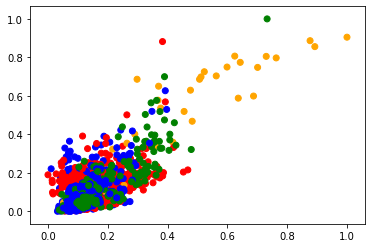


('spectral_centroid', 'std') vs. ('spectral_centroid', 'mean')


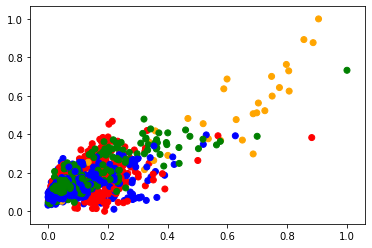

In [55]:
# DATA VISUALIZATION
single_feature_vectors = [[] for _ in range(len(x[0]))]
color_map = {"Baroque":"red", "Classical":"green",
            "Romantic":"blue", "Modern":"orange"}
colors = []
for k, data_pt in enumerate(agg_x):
    colors.append(color_map[agg_y[k]])
    for i in range(len(data_pt)):
        single_feature_vectors[i].append(data_pt[i])
for a in range(2):
    for b in range(2):
        if a != b:
            print(KEYWORDS[a], "vs.", KEYWORDS[b])
            plt.scatter(single_feature_vectors[a], single_feature_vectors[b], c=colors)
            plt.show()
            print()

In [27]:
x_train, x_test, y_train, y_test = train_test_split(agg_x, agg_y, test_size=0.2)

# Adaboost
AdaBoost is a boosting algorithm that iterates on the weights with multiple decision stumps to boost performance of these weak classifiers. The weights are first initialized as 1/n, with n being the size of the training set. These decision stumps are “weak” because the value of each weight is a threshold for each feature, dividing the dataset into four subsets based on the threshold value. In each iteration, the weight is updated according to the error measured by an exponential loss function. 

We chose Adaboost as our preliminary model because features we are using are simple and straightforward relative to the complex nature of the audio data. In order to reconcile the simplicity of the features with the complexity of task, we chose ensemble models that use weak classifiers to model a complex system. 

In [76]:
clf = AdaBoostClassifier(n_estimators=50, random_state=0, )
clf.fit(x_train, y_train)
print("Train accuracy:", clf.score(x_train, y_train))
print("Test accuracy:", clf.score(x_test, y_test))
print(clf.feature_importances_)

Train accuracy: 0.6400580551523948
Test accuracy: 0.5884057971014492
[0.02 0.14 0.1  0.1  0.08 0.1  0.14 0.1  0.1  0.12]


In [77]:
matrix = {}

for i, x in enumerate(x_test):
    g = clf.predict([x])[0]
    era = y_test[i]
    if (era, g) in matrix: matrix[(era,g)] += 1
    else: matrix[(era,g)] = 1
print(matrix)

{('Modern', 'Baroque'): 3, ('Baroque', 'Romantic'): 31, ('Romantic', 'Romantic'): 123, ('Baroque', 'Baroque'): 61, ('Classical', 'Romantic'): 35, ('Romantic', 'Baroque'): 16, ('Classical', 'Classical'): 16, ('Modern', 'Romantic'): 13, ('Classical', 'Baroque'): 15, ('Baroque', 'Classical'): 9, ('Romantic', 'Modern'): 4, ('Romantic', 'Classical'): 9, ('Modern', 'Classical'): 4, ('Modern', 'Modern'): 3, ('Classical', 'Modern'): 1, ('Baroque', 'Modern'): 2}


# Random Forest
Random Forest is an ensemble model that combines multiple simple decisions trees for added complexity. One key strength of Random Forest is the robustness against possible overfitting: each decision tree is instantiated randomly, it is more likely to capture the variation in the data. Another difference between Random Forest and Adaboost is that while the number of estimator parameter specifies the number of iteration in Adaboost, the number of estimator is a parameter for the number of decision trees to be constructed in a Random Forest classifier model. Instead of iterating each weight n times, Random Forest takes an average over n decision tree at the end. 

In [78]:
clf = RandomForestClassifier(n_estimators=50, max_depth=2, random_state=0)
clf.fit(x_train, y_train)
print("Train accuracy:", clf.score(x_train, y_train))
print("Test accuracy:", clf.score(x_test, y_test))
print(clf.feature_importances_)

Train accuracy: 0.6008708272859217
Test accuracy: 0.5594202898550724
[0.09432571 0.12601328 0.00848939 0.00476838 0.10975293 0.34168554
 0.06096997 0.03538372 0.01437037 0.20424071]


# Comparison of Models
Both models were trained with the number of estimator parameter = 50, and performed moderately well with an accuracy rate of ~0.60, which is 0.15 over the threshold value (0.45) and is comparable to the current level of success with genre classification. Nevertheless, an improvement in the performance is desired 60\% is barely over a majority value. Interestingly, the accuracy of models have consistently decreased from our preliminary results as we increased our data by one order of magnitude (100 -> +1700 data points). This suggests the failure of simple models in processing larger variations in a bigger data set and the necessity of more complex techniques, such as recurrent neural networks. Furthermore, while we expected Random Forest to perform better because it is more robust against over-fitting, Adaboost performed marginally better than Random Forest in both training and test set.

An examination of the weight assignment yields more insights into the performance of the two models. First, we observe that the weight assignment for the Adaboost is more uniform across the ten features compared to Random Forest. In fact, the weights for the Adaboost are all around 0.1 for every feature except the mean of the spectral centroid. This is consistent with our understanding of the algorithms because the Adaboost initializes the weight for each feature with 1/n = 1/10 = 0.1 and then updates the weights after each iteration. With our low number of iterations (n=50), it is understandable that the feature weights do not deviate strongly from the initial values. However, we surprisingly found that the Adaboost performs worse with a larger estimator, which suggests the inherent limitation in the algorithm to process complex data. Since the Random Forest merges observations of randomly initialized decision trees, it is more precise than the Adaboost in that it weighs stronger features more heavily. 

Two notable features for the Random Forest model are the standard deviation of the spectral rolloff (=0.35, over 1/3) and the standard deviation of tonal centroid (=.21). We've seen the importance of the former feature consistently in our previous experiments. For each audio segment, (i.e. for each audio frame), spectral rolloff is the frequency at which 85\% of the energy lies below the frequency, so the standard deviation of this feature reflects how the energy of a piece changes over time. Intuitively, this comes close to human "feeling" of a piece, which makes it a good feature. To illustrate, we expect the spectral energy to be more concentrated in the midrange of piano for a Baroque piece, in contrast with a modern piece, whose spectral energy is more likely to be widely dispersed throughout the possible frequency range. Similarly, the standard deviation of tonal centroid measures how harmonious the chords are in a piece, which is understandably a distinguishing factor for pieces across different eras.

In [79]:
matrix = {}

for i, x in enumerate(x_test):
    g = clf.predict([x])[0]
    era = y_test[i]
    if (era, g) in matrix: matrix[(era,g)] += 1
    else: matrix[(era,g)] = 1
print(matrix)

{('Modern', 'Baroque'): 10, ('Baroque', 'Romantic'): 42, ('Romantic', 'Romantic'): 132, ('Baroque', 'Baroque'): 61, ('Classical', 'Romantic'): 36, ('Romantic', 'Baroque'): 20, ('Classical', 'Baroque'): 31, ('Modern', 'Romantic'): 13}


# Error Analysis
First, we can see that the Adaboost classifier never predicted Classical or Modern on the test dataset, which reveals the limitation of the model based on weak classifiers. This model failed to account for the minority data of the pieces from the Classical and Modern eras and over-fitted to the more abundant data. 

In contrast, the Random Forest model seems provides a more nuanced classification, and we expect that this model would outperform the Adaboost with a larger scale data. We suspect the lower performance on our test set of the Random Forest to the relatively small size of our data. 

Since a near majority of the data was from the Romantic era, both models performed most successfully in predicting Romantic pieces. We expect to see a notable increase in the performance, especially in the Baroque, Classical, and Baroque data with more song data and more complex models.